## Super resolution

In [28]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [3]:
il = ImageList.from_folder(path_hr)

In [4]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [6]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

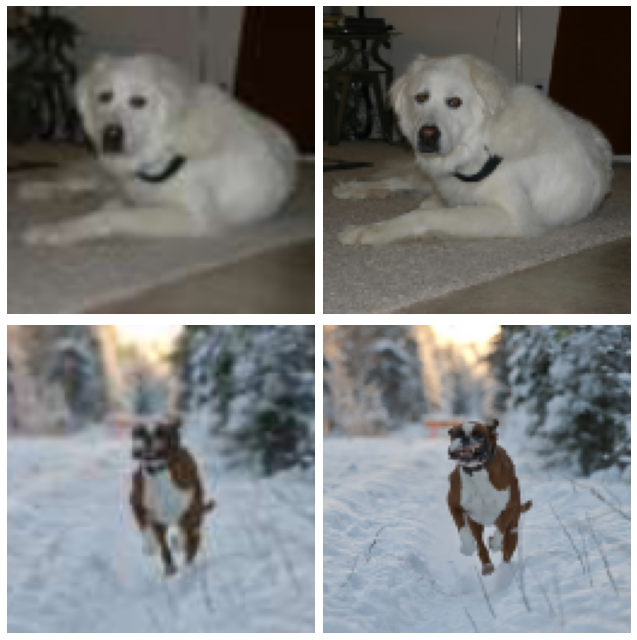

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
base_loss = F.l1_loss

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()

In [13]:
requires_grad(vgg_m, False)

In [14]:
blocks = [i-1 for i, l in enumerate(vgg_m)  if isinstance(l, nn.MaxPool2d)]
blocks

[5, 12, 22, 32, 42]

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, model, layer_ids, weights):
        super().__init__()
        self.model = model
        self.loss_features = [model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.weights = weights
        self.metric_names = ['pixel',] + ['feature_{}'.format(i) for i in range(len(layer_ids))] + ['gram_{}'.format(i) for i in range(len(layer_ids))]
    
    def make_features(self, x, clone=False):
        self.model(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, x_in, x_t):
        ft = self.make_features(x_t, clone=True)
        fi = self.make_features(x_in)
        losses = [base_loss(x_in, x_t)]
        losses += [base_loss(ft_i, fi_i)*w_i for (ft_i, fi_i, w_i) in zip(ft, fi, self.weights)]
        losses += [base_loss(gram_matrix(ft_i), gram_matrix(fi_i))*w_i**2 *5e3 for (ft_i, fi_i, w_i) in zip(ft, fi, self.weights)]
        self.metrics = dict(zip(self.metric_names, losses))
        return sum(losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [18]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,pixel,feature_0,feature_1,feature_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


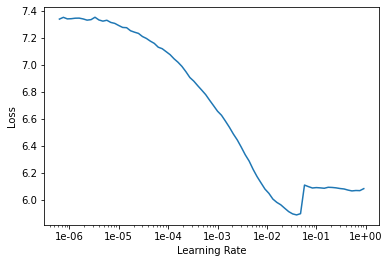

In [81]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3

In [23]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feature_0,feature_1,feature_2,gram_0,gram_1,gram_2,time
0,3.848499,3.717375,0.147586,0.227338,0.312018,0.223266,0.555114,1.193535,1.058518,01:05
1,3.740262,3.552487,0.141620,0.225138,0.303562,0.214500,0.511526,1.137523,1.018618,01:04
2,3.673649,3.537938,0.145792,0.224520,0.302292,0.211525,0.515803,1.135367,1.002639,01:04
3,3.648874,3.458188,0.146536,0.223381,0.297518,0.207552,0.491766,1.104505,0.986930,01:04
4,3.599994,3.402769,0.143650,0.221281,0.293407,0.203408,0.482387,1.092367,0.966271,01:04
5,3.545299,3.390603,0.141355,0.221209,0.292316,0.201962,0.486375,1.089479,0.957907,01:03
6,3.498314,3.305237,0.143916,0.218983,0.287560,0.197027,0.462021,1.061018,0.934714,01:03
7,3.464989,3.320584,0.141134,0.220593,0.287915,0.198040,0.463685,1.068828,0.940389,01:03
8,3.451113,3.249697,0.141681,0.219681,0.284138,0.193966,0.447966,1.041589,0.920675,01:03
9,3.327429,3.152966,0.136894,0.214859,0.276671,0.187976,0.429190,1.013972,0.893404,01:03


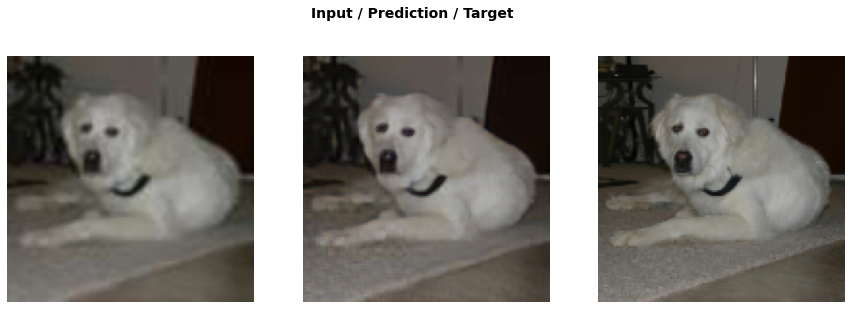

In [84]:
do_fit('1a', slice(lr*10))

In [85]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feature_0,feature_1,feature_2,gram_0,gram_1,gram_2,time
0,3.315058,3.145440,0.136498,0.214605,0.276251,0.187640,0.426214,1.011828,0.892403,01:06
1,3.301567,3.140031,0.136854,0.214635,0.276004,0.187337,0.424930,1.009755,0.890515,01:06
2,3.301797,3.132649,0.136881,0.214447,0.275597,0.186840,0.423076,1.007498,0.888312,01:06
3,3.295433,3.126826,0.136250,0.214199,0.275176,0.186361,0.422416,1.006318,0.886106,01:06
4,3.284999,3.119661,0.135983,0.213623,0.274844,0.185945,0.420963,1.004810,0.883492,01:06
5,3.288671,3.118761,0.135652,0.213201,0.273996,0.185654,0.423433,1.003019,0.883806,01:06
6,3.285956,3.113012,0.137942,0.213927,0.274418,0.185722,0.415779,1.000446,0.884778,01:06
7,3.274395,3.105311,0.136535,0.213047,0.273121,0.184804,0.418046,0.999302,0.880458,01:06
8,3.248055,3.101547,0.135550,0.212359,0.272808,0.184935,0.416794,0.997482,0.881618,01:06
9,3.257159,3.082170,0.135645,0.212217,0.271930,0.183597,0.413022,0.991838,0.873921,01:06


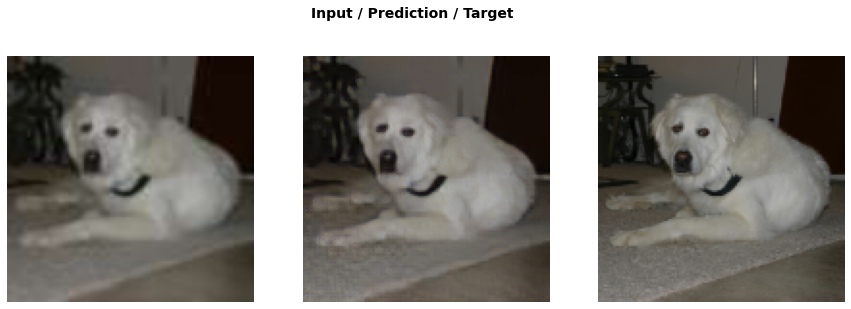

In [86]:
do_fit('1b', slice(1e-5,lr))

In [29]:
data = get_data(12,size*2)

In [30]:
learn.data = data
learn.freeze()
gc.collect()

13699

In [31]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feature_0,feature_1,feature_2,gram_0,gram_1,gram_2,time
0,2.238723,2.192882,0.163523,0.259720,0.294213,0.154233,0.378896,0.577575,0.364722,04:14
1,2.199130,2.168877,0.164629,0.260106,0.292618,0.153087,0.366687,0.571097,0.360652,04:05
2,2.174178,2.151802,0.165776,0.259535,0.290719,0.151686,0.359519,0.567241,0.357326,04:05
3,2.155674,2.128098,0.165908,0.258825,0.288794,0.150646,0.351233,0.558156,0.354536,04:05
4,2.140327,2.128467,0.168481,0.259383,0.288321,0.150630,0.348856,0.559043,0.353754,04:05
5,2.119933,2.102062,0.165577,0.257598,0.286029,0.148940,0.343083,0.550554,0.350282,04:05
6,2.117413,2.101967,0.170963,0.257412,0.284654,0.147671,0.340568,0.552978,0.347721,04:05
7,2.096283,2.082843,0.167807,0.258257,0.285368,0.147884,0.330693,0.546230,0.346603,04:05
8,2.070496,2.087615,0.166779,0.256887,0.283106,0.146482,0.340186,0.549383,0.344792,04:05
9,2.062169,2.060114,0.165327,0.255654,0.282270,0.145816,0.326663,0.541037,0.343347,04:05


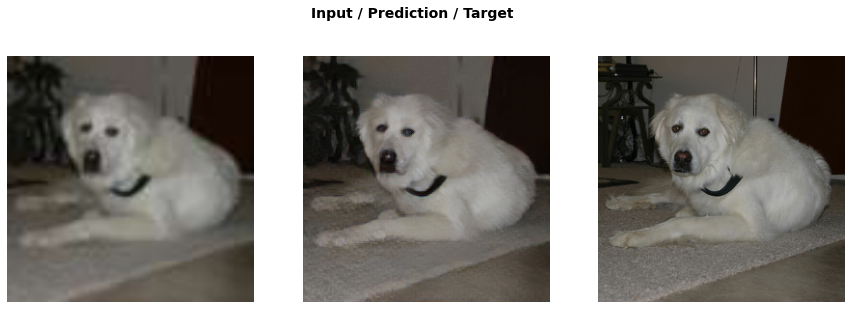

In [32]:
do_fit('2a')

In [33]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feature_0,feature_1,feature_2,gram_0,gram_1,gram_2,time
0,2.054111,2.056436,0.165159,0.254782,0.281316,0.145556,0.327586,0.539549,0.342488,04:15
1,2.054743,2.054734,0.164945,0.254616,0.281042,0.145289,0.328004,0.538923,0.341915,04:15
2,2.048231,2.053370,0.164730,0.254565,0.281080,0.145254,0.327299,0.538616,0.341827,04:15
3,2.048658,2.051237,0.166265,0.255207,0.281466,0.145360,0.323846,0.537481,0.341613,04:15
4,2.047705,2.050647,0.164645,0.254853,0.280874,0.144861,0.326525,0.537969,0.340920,04:15
5,2.056159,2.045297,0.164884,0.254086,0.280259,0.144784,0.324819,0.536071,0.340394,04:15
6,2.050989,2.046217,0.165928,0.254926,0.280864,0.145098,0.322626,0.536031,0.340743,04:15
7,2.044763,2.043573,0.165193,0.254446,0.280383,0.144888,0.323073,0.535355,0.340236,04:15
8,2.040176,2.043823,0.165622,0.254800,0.280508,0.144886,0.322522,0.535307,0.340178,04:15
9,2.038504,2.043902,0.165663,0.254633,0.280434,0.144837,0.322867,0.535321,0.340147,04:15


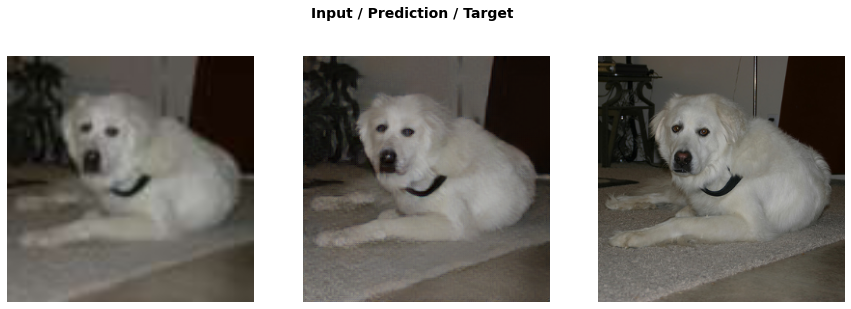

In [34]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)